<a href="https://colab.research.google.com/github/takehiro161013/kaggle_houseprice/blob/main/house_price3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<a href="https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard">Stacked Regressions : Top 4% on LeaderBoard</a>を参考<br>
てか丸パクリ<br>
ディレクトリは各自で<br>
参考url<br>
https://www.kaggle.com/takizawa/kaggle-tutorial-house-prices?scriptVersionId=1081693<br>
https://github.com/CodeSeterpie/CodeSeterpie/blob/develop/Kaggle/HousePrices/input/data_description_ja.md<br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output
print(check_output(["ls", "/content/drive/MyDrive/Colab Notebooks/house-prices-advanced-regression-techniques/input"]).decode("utf8")) #check the files available in the directory

sample_submission.csv
test.csv
train.csv



In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/house-prices-advanced-regression-techniques/"

df = pd.read_csv(path + 'input/train.csv')
df_test = pd.read_csv(path + 'input/test.csv')
submission = pd.read_csv(path + 'output/sample_submission.csv')

In [ ]:
all_df = pd.concat([df, df_test]).reset_index(drop=True)
all_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,...,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,...,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,...,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,...,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,...,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,...,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,...,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,...,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitche

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
歪度: 1.8829
尖度: 6.5363


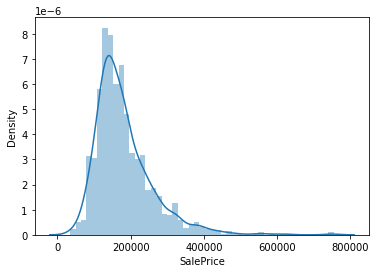

In [ ]:
# 売却価格のヒストグラム
sns.distplot(df['SalePrice'])
# 売却価格の概要をみてみる
print(df["SalePrice"].describe())
print(f"歪度: {round(df['SalePrice'].skew(),4)}" )
print(f"尖度: {round(df['SalePrice'].kurt(),4)}" )

In [ ]:
all_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [ ]:
def show_missing(df):
    missing_list = df.isnull().sum().sort_values(ascending=False) / df.shape[0]
    missing_list = missing_list[missing_list>0]

    plt.subplots(figsize=(12, 6))
    plt.xticks(rotation=90)
    sns.barplot(missing_list.index, missing_list.values)

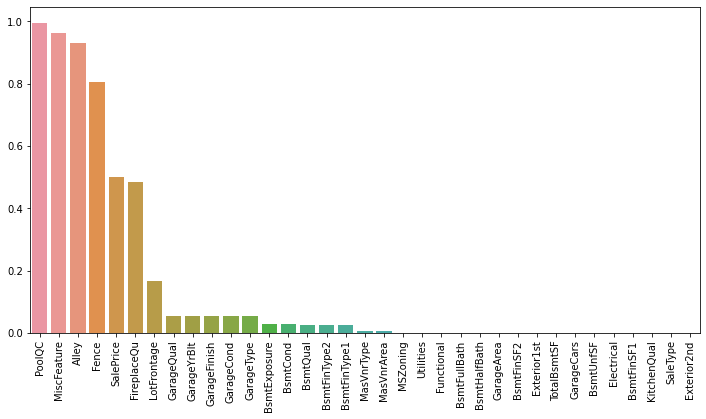

In [ ]:
show_missing(all_df)

In [ ]:
# 変数の型ごとに欠損値の扱いが異なるため、変数ごとに処理
for column in all_df.columns:
    # dtypeがobjectの場合、文字列の変数
    if all_df[column].dtype=='O':
        all_df[column] = all_df[column].fillna('None')
    # dtypeがint , floatの場合、数字の変数
    else:
        all_df[column] = all_df[column].fillna(0)

In [ ]:
all_df.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       486
LotArea             0
                 ... 
MoSold              0
YrSold              0
SaleType            1
SaleCondition       0
SalePrice        1459
Length: 81, dtype: int64

In [ ]:
#サンプル数、フィーチャー数の確認
print("The train data size before dropping Id feature is : {} ".format(df.shape))
print("The test data size before dropping Id feature is : {} ".format(df_test.shape))

#Save the 'Id' column
train_ID = df['Id']
test_ID = df_test['Id']

#「Id」列は予測処理には不要なので削除
df.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

#「Id」変数を削除した後、データサイズを再確認する
print("\nThe train data size after dropping Id feature is : {} ".format(df.shape)) 
print("The test data size after dropping Id feature is : {} ".format(df_test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


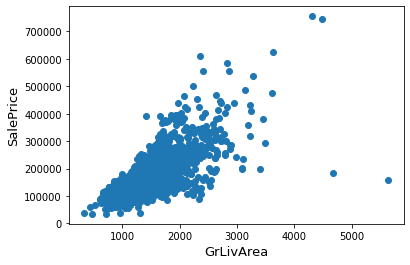

In [ ]:
#GrLIvAreaとSalePriceとの相関
fig, ax = plt.subplots()
ax.scatter(x = df['GrLivArea'], y = df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

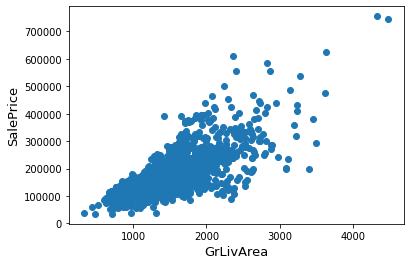

In [ ]:
#外れ値を削除したグラフ
df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(df['GrLivArea'], df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


 mu = 180932.92 and sigma = 79467.79



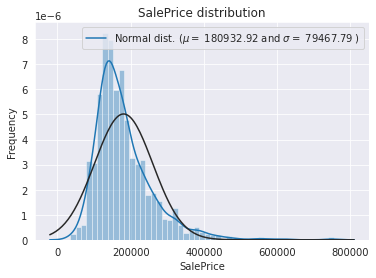

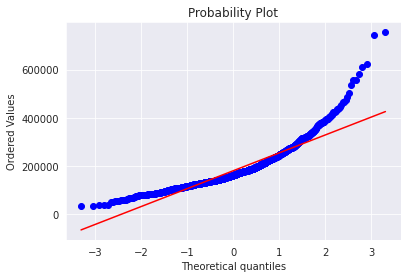

In [ ]:
sns.distplot(df['SalePrice'] , fit=norm);

# 関数で使用するフィットパラメータを取得
(mu, sigma) = norm.fit(df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#分布をプロット
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#QQ-plotも表示
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)
plt.show()

左に偏っているので正規分布のデータとするように対数変換を行う<br>
対数変換については<a herf="https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python">Comprehensive data exploration with Python</a>がわかりやすい


 mu = 12.02 and sigma = 0.40



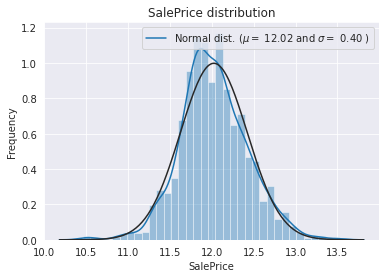

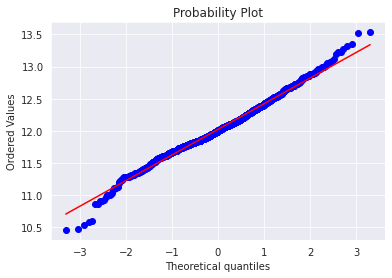

In [ ]:
#対数変換
df["SalePrice"] = np.log1p(df["SalePrice"])

#新しいディストリビューションを確認
sns.distplot(df['SalePrice'] , fit=norm);

# 関数が使用するフィットパラメータを取得
(mu, sigma) = norm.fit(df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)
plt.show()

In [ ]:
ntrain = df.shape[0]
ntest = df_test.shape[0]
y_train = df.SalePrice.values
all_data = pd.concat((df, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


In [ ]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageYrBlt,5.451
GarageQual,5.451
GarageCond,5.451


Text(0.5, 1.0, 'Percent missing data by feature')

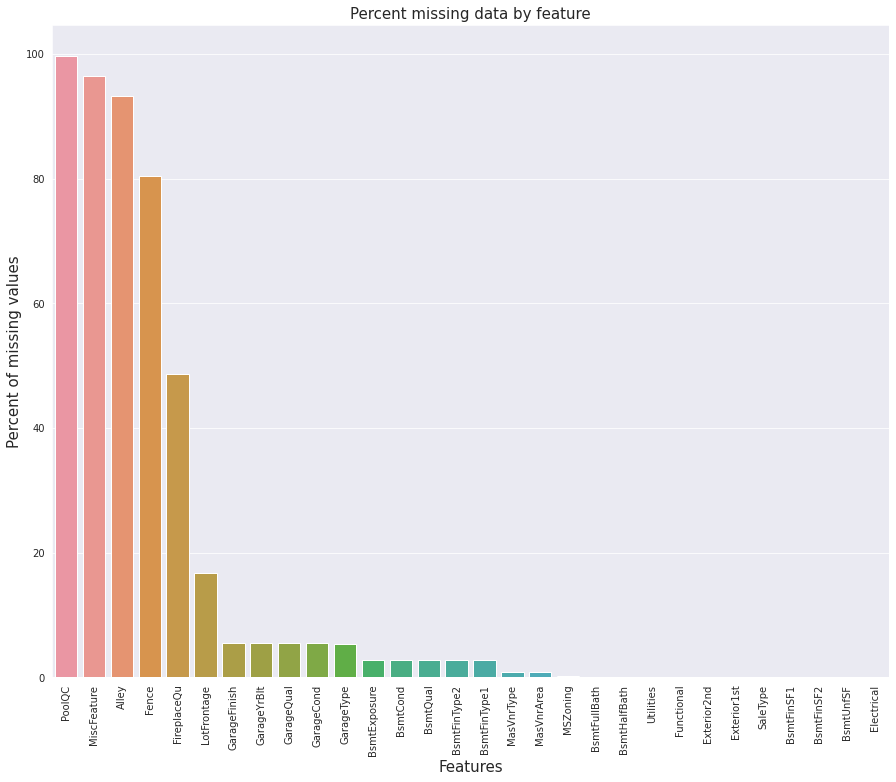

In [ ]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)


Correlation matrixについても<a herf="https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python">Comprehensive data exploration with Python</a>をみて見るとよく分かる


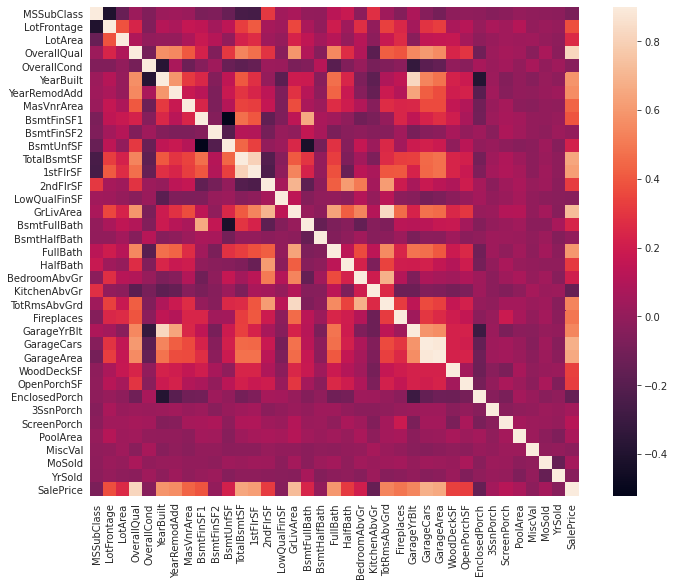

In [ ]:
#Correlation map to see how features are correlated with SalePrice
corrmat = df.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

欠損データの補完、削除を行う


In [ ]:
#PoolQC : データの説明によると、NAは「プールがない」という意味だそうです。欠損値の割合が99%と非常に大きく、一般的にプールがない家が多いことを考えると、納得できます。

all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

In [ ]:
#no misk feature
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

In [ ]:
#no alley access
all_data["Alley"] = all_data["Alley"].fillna("None")

In [ ]:
#no fence
all_data["Fence"] = all_data["Fence"].fillna("None")

In [ ]:
#no fireplace
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

In [ ]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [ ]:
#欠損データをNoneに置き換える
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

In [ ]:
#欠損データをNoneに置き換える(ガレージがない＝ガレージに車がないということ)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [ ]:
#欠損値は、地下室がない場合はゼロである
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [ ]:
#地下室関連の特徴について、NaNは地下室がないことを意味する
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [ ]:
#NA は、これらの家に石積みのベニヤがないことを意味している可能性が高い
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [ ]:
#RL'が圧倒的に多い値です。そのため、不足している値を'RL'で埋めることができます。
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [ ]:
#役に立たないモデルを削除
all_data = all_data.drop(['Utilities'], axis=1)

In [ ]:
#機能 : データの説明では、NAは典型的なものを意味します。
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [ ]:
#この機能はほとんどが「SBrkr」なので、それを欠損値に設定することができます
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [ ]:
#NA値は1つだけで、Electricalと同じように、KitchenQualの欠損値に（最も頻度の高い）「TA」を設定しています。
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

In [ ]:
#1つだけ欠損値があります。最も一般的な文字列で代用する
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

In [ ]:
#販売タイプ。最も頻度の高い "WD "を入力
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [ ]:
#NaはNo building classを意味する可能性が高い。欠損値をNoneに置き換えることができる。
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [ ]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [ ]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)


In [ ]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


In [ ]:
# Adding 合計の家面積 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [ ]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# すべての数値機能のskewを確認
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


(高度に)傾いた特徴量のBox Cox変換

1+x の Box-Cox 変換を計算する scipy 関数 boxcox1p を使用します。

λ=0に設定することは、上記で対象変数に使用したlog1pと同等であることに注意してください。

Box Cox 変換の詳細については，<a href="https://onlinestatbook.com/2/transformations/box-cox.html">このページ</a>と <a href="https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html">scipy 関数</a>のページを参照



In [ ]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 59 skewed numerical features to Box Cox transform


In [ ]:
#カテゴリカルダミー変数の取得
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [ ]:
#新しいdfとdf_testセットの入手
df = all_data[:ntrain]
df_test = all_data[ntrain:]

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

クロスバリデーション戦略の定義

Sklearnのcross_val_score関数を使用します。しかし、この関数にはshuffle属性がないので、クロスバリデーションの前にデータセットをシャッフルするために、1行のコードを追加します。

In [ ]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df.values)
    rmse= np.sqrt(-cross_val_score(model, df.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

様々な回帰手法を使ってモデルを作成する<br>
<a href="https://qiita.com/Takayoshi_Makabe/items/8f6dcb25124b9dcb1ae8">ラッソ回帰</a><br>
<a href="https://aizine.ai/ridge-lasso-elasticnet/#toc9">ElasticNet回帰</a><br>
<a herf="">カーネルリッジ回帰</a><br>
<a herf="">勾配ブースティング回帰</a><br>
<a herf="">light GBM</a><br>
<a herf="">XGBoost</a><br>



In [ ]:
#ラッソ回帰
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [ ]:
#エラスティックネット回帰
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [ ]:
#カーネルリッジ回帰
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [ ]:
#勾配ブースティング回帰
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [ ]:
#light GBM
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [ ]:
#XGBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [ ]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)



In [ ]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



In [ ]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)



In [ ]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1167 (0.0083)



In [ ]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1176 (0.0062)



In [ ]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1150 (0.0066)



まず、ベースモデルを平均化するというシンプルなアプローチから始めます。scikit-learnを我々のモデルで拡張し、カプセル化とコードの再利用（継承）を平均化するために、新しいクラスを構築します。

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [ ]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1087 (0.0077)



よりシンプルな積み上げ方：メタモデルの追加
この方法では，平均化されたベースモデルの上にメタモデルを追加し，ベースモデルのフォールド外予測を使ってメタモデルを学習します．

学習部分の手順は、以下のようになります。

全体のトレーニングセットを2つの離散したセット（ここではtrainと.holdout）に分割する。

最初の部分でいくつかのベースモデルを学習する（train）。

これらのベースモデルを第2の部分（holdout）でテストする。

3)で得られた予測（out-of-folds predictionsと呼ばれる）を入力とし、正解（target variable）を出力として、メタモデルと呼ばれる上位の学習者を学習します。

最初の3つのステップは繰り返し行われます。例えば、5フォールドスタッキングを例にとると、まず学習データを5つのフォールドに分割します。そして、5回の反復を行います。各反復において、4つのフォールドですべてのベースモデルを学習し、残りのフォールド（ホールドアウトフォールド）で予測を行います。

したがって、5回の反復後には、データ全体を使ってフォールド外の予測が得られていることを確認し、ステップ4でメタモデルを訓練するための新しい特徴として使用します。

予測の部分では、テストデータに対するすべてのベースモデルの予測を平均化し、それらをメタモデルで最終的な予測を行うためのメタ特徴として使用します。<br>https://www.slideshare.net/HJvanVeen/kaggle-presentation
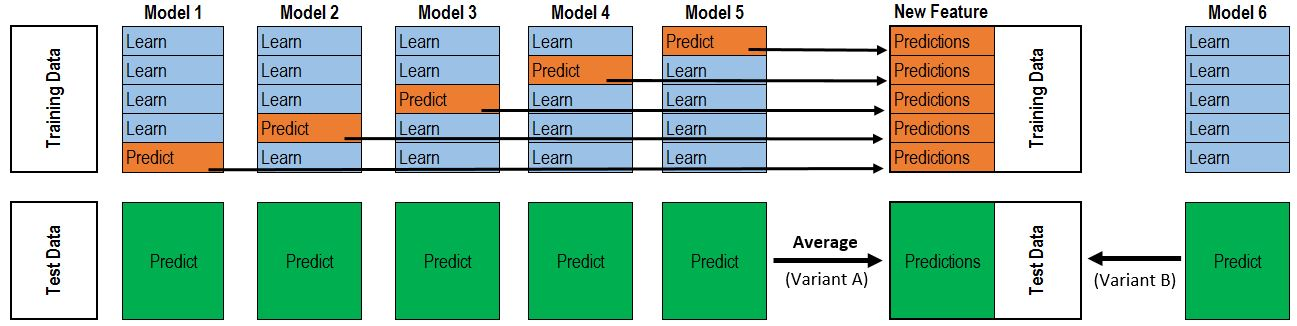

In [ ]:
#スタックアベレージモデルクラス
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # 元のモデルのクローンを使って再びデータをフィットさせる
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # クローン化されたベースモデルを学習し、アウトオブフォールドの予測を行う
        # 複製されたメタ・モデルを訓練するために必要とされる
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        #フォールド外の予測値を新しい特徴として、クローンされたメタモデルを学習します。
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #全てのベースモデルの予測をテストデータに対して行い、平均化された予測値をメタモデルの最終予測に使用します。
    #メタモデルが行う最終的な予測のためのメタ特性として使用します。
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [ ]:
#2つのアプローチを比較できるように（同じ数のモデルを使用して）、Enet KRRとGboostを平均し、メタモデルとしてlassoを追加しています。
#モデルスコアを出す
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1081 (0.0073)


最終的なトレーニングと予測

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
#StackedRegressor
stacked_averaged_models.fit(df.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(df.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(df_test.values))
print(rmsle(y_train, stacked_train_pred))

0.07839506096664628


In [ ]:
#XGBoost
model_xgb.fit(df, y_train)
xgb_train_pred = model_xgb.predict(df)
xgb_pred = np.expm1(model_xgb.predict(df_test))
print(rmsle(y_train, xgb_train_pred))

0.0788580427618937


In [ ]:
#light GBM
model_lgb.fit(df, y_train)
lgb_train_pred = model_lgb.predict(df)
lgb_pred = np.expm1(model_lgb.predict(df_test.values))
print(rmsle(y_train, lgb_train_pred))

0.07294132053731643


In [ ]:
#'''平均化した場合のTrainデータ全体のRMSE'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.60 +
               xgb_train_pred*0.20 + lgb_train_pred*0.20 ))

RMSLE score on train data:
0.07504601258254061


<a href="https://qiita.com/hkthirano/items/2c35a81fbc95f0e4b7c1">アンサンブル予測について</a>


In [ ]:
#アンサンブル予測
print("最高スコア0.11984")
ensemble = stacked_pred*0.60 + xgb_pred*0.20 + lgb_pred*0.20

最高スコア0.11984


In [ ]:
print("LGBMのみの場合Score0.12315")
ensemble = lgb_pred

SyntaxError: ignored

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)

In [ ]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>